In [635]:
import pandas as pd
import numpy as np
import json
#import xgboost as xgb
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

pd.set_option('display.max_columns', None)

In [636]:
team_metrics_df = pd.read_csv("team_metric_df.csv")
team_metrics_df["over_xg"] = team_metrics_df["goal"]  - team_metrics_df["statsbomb_xg"] 
team_metrics_df = team_metrics_df[team_metrics_df.penalty==0]
print(len(team_metrics_df))
team_metrics_df = team_metrics_df.fillna(0)

458720


In [637]:
team_metrics_df["Count High Acceleration_1_week"].mean()

np.float64(11.88875835011955)

In [638]:
team_metrics_df["Count High Deceleration_1_week"].mean()

np.float64(13.774319448332097)

In [639]:
team_metrics_df["High Speed Running (HSR) Distance_1_week"].mean()

np.float64(250.64876282528218)

In [640]:
team_metrics_df["Sprinting Distance_1_week"].mean()

np.float64(103.32886552341186)

In [641]:
def workload_index(df, period):
    # Extract the relevant columns for the period
    metrics = [
        df[f"Count High Deceleration_{period}"],
        df[f"Count High Acceleration_{period}"],
        df[f"High Speed Running (HSR) Distance_{period}"],
        df[f"Sprinting Distance_{period}"]
    ]
    
    # Stack all metrics to compute overall min and max
    all_metrics = pd.concat(metrics, axis=0)
    
    # Normalize each metric between 0 and 1
    normalized_metrics = []
    for metric in metrics:
        normalized = (metric - all_metrics.min()) / (all_metrics.max() - all_metrics.min())
        normalized_metrics.append(normalized)
    
    # Sum the normalized metrics (equal weighting)
    return sum(normalized_metrics)



In [642]:
def workload_index2(df, period):
    return (
        abs(df[f"Count High Deceleration_{period}"]) +
        abs(df[f"Count High Acceleration_{period}"]) +
        
        abs(df[f"High Speed Running (HSR) Distance_{period}"]) +
        abs(df[f"Sprinting Distance_{period}"]) 
        ##abs(df[f"Running Distance_{period}"]) +#orig
        
    )

# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    team_metrics_df[f"WI_{period}"] = workload_index(team_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
team_metrics_df["ACWR"] = (team_metrics_df["WI_1_week"])/ (team_metrics_df["WI_1_month"]/4)#
team_metrics_df["ACWR"] = np.where(team_metrics_df["ACWR"].isna(), 0,team_metrics_df["ACWR"])
team_metrics_df["ACWR_bucket"] = pd.cut(
    team_metrics_df["ACWR"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]#, "Q4"
)
team_metrics_df["ACWR_pos"] = np.where(team_metrics_df["ACWR"]>0, 1,0)

In [643]:

team_metrics_df["ACWR"].quantile([0,0.25,0.5,0.75,1]) 

0.00     0.000000
0.25     0.000000
0.50     0.525734
0.75     2.491384
1.00    10.256797
Name: ACWR, dtype: float64

In [644]:
team_metrics_df = team_metrics_df[(team_metrics_df.WI_1_month!=0)]

In [645]:
team_metrics_df[["event_id","shot_team_id","ACWR"]].groupby(["event_id","shot_team_id"], as_index=False).mean()

,event_id,shot_team_id,ACWR
0,000192ca-5d86-4797-af38-7fe2d14d9861,24.0,1.644497
1,0005426e-2055-411b-9e10-36af8f9afb72,214.0,2.001836
2,0005615c-e54c-458d-b044-715bbfdeb75b,222.0,0.000000
3,0006ca8e-9b8f-436c-8968-baf6d276523a,172.0,0.000000
4,0006eec8-f7bd-4dc7-9ca1-1b9fe26bb3b7,172.0,0.000000
...,...,...,...
43965,fffb3836-1bcc-4cfa-9c6a-f6c54e63a4e6,36.0,2.552026
43966,fffb428d-7dd3-49cd-874c-9e0bc11fe35c,182.0,0.830821
43967,fffbc90f-b581-4975-940b-d2989f34e6fe,205.0,0.000000
43968,fffcc07f-ad47-49eb-a261-1b6c827a6ad7,872.0,0.000000


In [646]:
team_metrics_df
group_col = ["event_id","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]


team_agg_df = team_metrics_df[["event_id","shot_team_id","ACWR","statsbomb_xg"]].groupby(["event_id","shot_team_id"], as_index=False).mean()#.drop("event_id",axis=1)
#team_agg_df = event_agg_df.groupby("shot_team_id", as_index=False).mean()

#other_cols = [col for col in team_metrics_df.columns if col not in group_col]

#agg_dict = {mean_col: ['mean']}
#agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

#team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
#team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
#                                for col in team_metrics_df.columns]

team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)
team_agg_df = team_agg_df[team_agg_df["ACWR"]>0]
team_agg_df

,event_id,shot_team_id,ACWR,statsbomb_xg,ACWR_bucket
0,000192ca-5d86-4797-af38-7fe2d14d9861,24.0,1.644497,0.068080,Q2
1,0005426e-2055-411b-9e10-36af8f9afb72,214.0,2.001836,0.028856,Q2
5,00074cc7-844c-43ca-b79d-291be3da4d6e,212.0,2.231522,0.022532,Q2
7,000821fd-7d49-4fd3-9238-e5e299801e5d,39.0,2.029390,0.029118,Q2
8,000854dc-4d6b-45cd-ac57-e8ad16e5fe5d,182.0,1.754355,0.210336,Q2
...,...,...,...,...,...
43961,fff10ce0-ab64-47aa-b66e-4392d27fc3e5,37.0,2.525791,0.140125,Q3
43963,fff1900c-6ff6-45cb-b30b-a8d2a64329da,207.0,5.151230,0.122133,Q3
43964,fffaf9f5-f849-41ac-885e-4f78e6fa503d,182.0,1.262969,0.067922,Q2
43965,fffb3836-1bcc-4cfa-9c6a-f6c54e63a4e6,36.0,2.552026,0.053872,Q3


<Axes: ylabel='Density'>

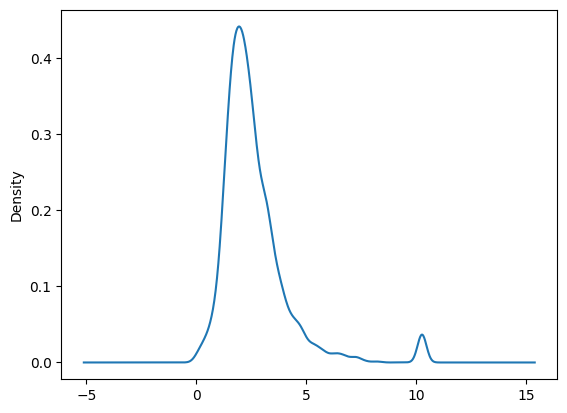

In [647]:
team_agg_df.ACWR.plot.density()

<Axes: xlabel='statsbomb_xg', ylabel='ACWR'>

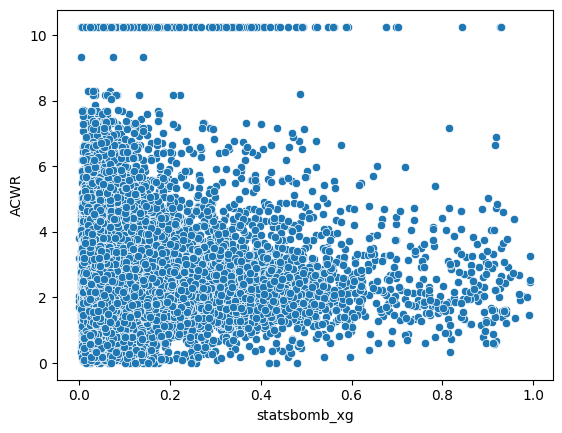

In [648]:

sns.scatterplot(data=team_agg_df, x="statsbomb_xg", y="ACWR")

see if overall team tiredness affects shots and team creation

group by gameId and event number, with summed metrics and individual metrics and group and indivd acwr? but first xg and over_xg

In [649]:
group_col = ["event_id","shot_team_id"]#
mean_col = 'statsbomb_xg'#"over_xg"#

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)

#team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='statsbomb_xg_first').reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)

<Axes: ylabel='Density'>

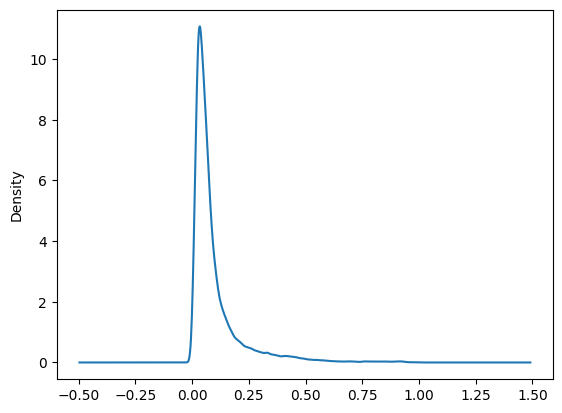

In [650]:
team_metrics_df.statsbomb_xg.plot.density()

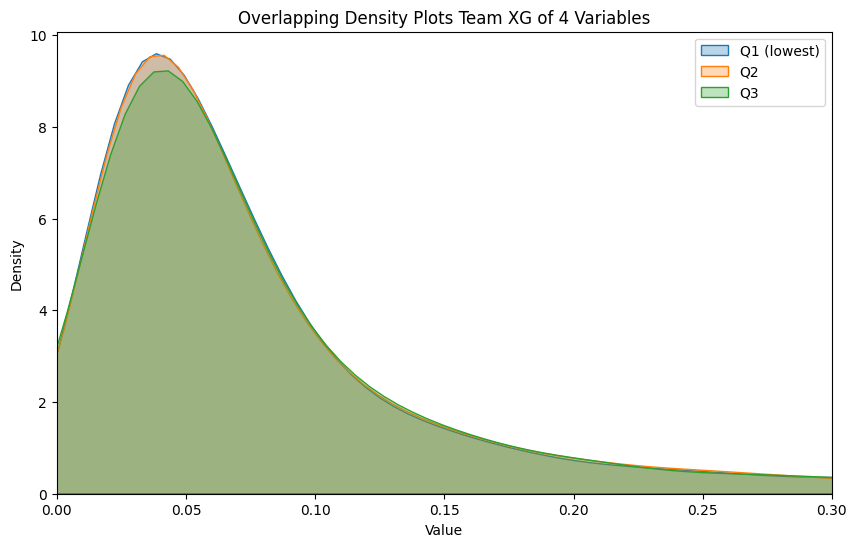

In [651]:
plt.figure(figsize=(10, 6))
for column in df_wide.columns:
    sns.kdeplot(df_wide[column], label=column, fill=True, alpha=0.3)
plt.xlim(-0.0,.3)
plt.title('Overlapping Density Plots Team XG of 4 Variables')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.show()

In [652]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import numpy as np
df = team_agg_df.copy()
# Encode the categorical variable
le = LabelEncoder()
X_encoded = le.fit_transform(df['ACWR_bucket']).reshape(-1, 1)
y = df['statsbomb_xg_first']

# Fit the model
model = LinearRegression()
model.fit(X_encoded, y)

# Print coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R-squared:", model.score(X_encoded, y))



Intercept: 0.09695219843658603
Coefficients: [0.0011624]
R-squared: 5.798767679043859e-05


In [653]:
X = df['ACWR_bucket']
mod = sm.OLS(y,X_encoded)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

In [654]:
print(p_values)

x1    0.0
Name: P>|t|, dtype: float64


In [655]:
df_wide.quantile([0,0.25,0.5,0.75,1]) #use?

,Q1 (lowest),Q2,Q3
0.00,0.002651,0.000180,0.000180
0.25,0.032982,0.033092,0.033413
0.50,0.057935,0.057764,0.058206
0.75,0.104779,0.107071,0.107052
1.00,0.976285,0.993749,0.994219


In [656]:
df_wide.median()

Q1 (lowest)    0.057935
Q2             0.057764
Q3             0.058206
dtype: float64

In [657]:
df_wide.mean() #use 

Q1 (lowest)    0.096867
Q2             0.098301
Q3             0.099145
dtype: float64

In [658]:
group_col = ["event_id","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)

#team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='statsbomb_xg_first').reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)

In [659]:
df_wide.mean()

Q1 (lowest)    0.096867
Q2             0.098301
Q3             0.099145
dtype: float64

In [660]:
teamlist = team_metrics_df[["shot_team_id","team_name"]].drop_duplicates()

In [661]:
standard_pl_teams = [
    'Arsenal', 'Aston Villa', 'AFC Bournemouth', 'Brentford', 'Brighton & Hove Albion',
    'Chelsea', 'Crystal Palace', 'Everton', 'Fulham',
    'Liverpool','Manchester City', 'Manchester United',
    'Newcastle United', 'Nottingham Forest',
    'Tottenham Hotspur', 'West Ham United', 'Wolverhampton Wanderers',
    'Ipswich Town', 'Leicester City', 'Southampton'
]

In [662]:
bundesliga_teams = [
    # 2023/24 teams
    'Bayern Munich', 'Bayern München', 'FC Bayern Munich', 'FC Bayern München',
    'Bayer Leverkusen', 'Bayer 04 Leverkusen', 'Leverkusen',
    'VfB Stuttgart', 'Stuttgart',
    'RB Leipzig', 'RasenBallsport Leipzig',
    'Borussia Dortmund', 'Borussia Dortmund', 'BVB', 'Dortmund',
    'Eintracht Frankfurt', 'Frankfurt', 'Eintracht',
    'TSG Hoffenheim', 'Hoffenheim', 'TSG 1899 Hoffenheim',
    'SC Freiburg', 'Freiburg', 'Sport-Club Freiburg',
    'FC Heidenheim', 'Heidenheim', '1. FC Heidenheim',
    'VfL Wolfsburg', 'Wolfsburg',
    'FC Augsburg', 'Augsburg', 'FC Augsburg 1907',
    'Borussia Mönchengladbach', 'Mönchengladbach', 'Gladbach', 'Borussia MGB',
    'Werder Bremen', 'Bremen', 'SV Werder Bremen',
    'Union Berlin', '1. FC Union Berlin',
    '1. FC Köln', 'Köln', 'Cologne', 'FC Köln',
    'Mainz 05', 'Mainz', '1. FSV Mainz 05',
    'VfL Bochum', 'Bochum', 'VfL Bochum 1848',
    'Darmstadt 98', 'Darmstadt', 'SV Darmstadt 98',
    
    # 2024/25 teams (including promoted teams)
    'St. Pauli', 'FC St. Pauli', 'FC Sankt Pauli',
    'Holstein Kiel', 'Kiel', 'KSV Holstein Kiel'
]

In [663]:
import datetime as dt

In [713]:
group_col = ["match_date","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)
teamname_agg = team_agg_df.merge(teamlist, on="shot_team_id",how="left")
teamname_agg = teamname_agg[teamname_agg.team_name.isin(standard_pl_teams)]
teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'], format='%Y-%m-%d')
teamname_agg = teamname_agg[teamname_agg.match_date>dt.datetime(2024,8,1)]


In [714]:
#teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'])
#teamname_agg['week_start'] = teamname_agg['match_date'].dt.to_period('W').dt.start_time
#teamname_agg.to_csv("new_dlnm.csv")#[(teamname_agg.match_date=="2023-08-18")]

In [715]:
df = teamname_agg[["match_date","shot_team_id","ACWR_bucket"	,"statsbomb_xg_first"]].groupby(["match_date","shot_team_id","ACWR_bucket"],as_index=False,observed=True).mean()

In [716]:
df

,match_date,shot_team_id,ACWR_bucket,statsbomb_xg_first
0,2024-08-24,1.0,Q1 (lowest),0.036816
1,2024-08-24,22.0,Q3,0.026338
2,2024-08-24,25.0,Q1 (lowest),0.048793
3,2024-08-24,29.0,Q1 (lowest),0.143096
4,2024-08-24,31.0,Q3,0.049278
...,...,...,...,...
731,2025-05-25,46.0,Q2,0.030180
732,2025-05-25,53.0,Q1 (lowest),0.053526
733,2025-05-25,55.0,Q1 (lowest),0.046144
734,2025-05-25,59.0,Q1 (lowest),0.053549


In [717]:
def look_back_same_team(df, column_to_get, team_col='shot_team_id', lookback=1):
    result = []
    team_history = {}  # Track recent history for each team
    
    for i in range(len(df)):
        current_team = df.iloc[i][team_col]
        
        # Initialize team in history if not present
        if current_team not in team_history:
            team_history[current_team] = []
        
        # Get the value from lookback positions ago for this team
        if len(team_history[current_team]) >= lookback:
            found_value = team_history[current_team][-lookback]  # lookback-th most recent
        else:
            found_value = np.nan
        
        # Add current value to team's history
        team_history[current_team].append(df.iloc[i][column_to_get])
        
        result.append(found_value)
    
    return result

# Example usage: get statsbomb_xg_first from 4 rows back for the same team
#df['statsbomb_xg_first_4_back'] = look_back_same_team(df, 'statsbomb_xg_first')

# You can apply this to any column you need
df['ACWR_lag_4'] = look_back_same_team(df, 'ACWR_bucket')

In [718]:
df2 = df[~df["ACWR_lag_4"].isna()].copy()

In [719]:
df_wide = df.pivot(columns='ACWR_lag_4', values='statsbomb_xg_first').reset_index()
df_wide.columns.name = None
#df_wide = df_wide.drop('event_id',axis=1)

In [720]:
df_wide.mean()

index          367.500000
NaN              0.130974
Q1 (lowest)      0.100079
Q2               0.092230
Q3               0.093335
dtype: float64

<Figure size 1200x600 with 0 Axes>

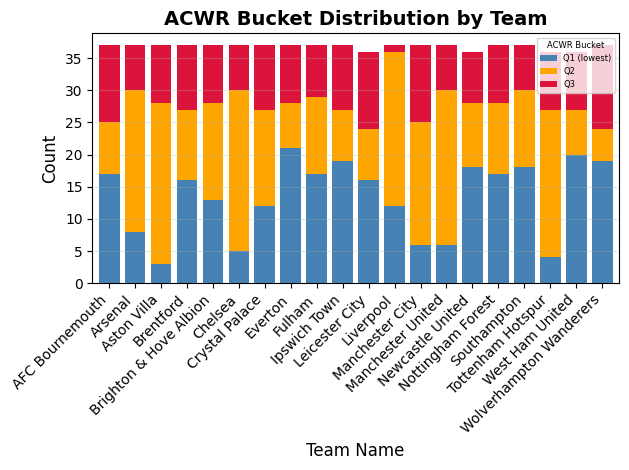

In [721]:
cross_tab = pd.crosstab(teamname_agg['team_name'], teamname_agg['ACWR_bucket'])

# Ensure all 4 ACWR buckets are present (even if some have zero counts)
all_buckets = ['Q1 (lowest)', 'Q2', 'Q3']
for bucket in all_buckets:
    if bucket not in cross_tab.columns:
        cross_tab[bucket] = 0

# Reorder columns to match Q1-Q4 sequence
cross_tab = cross_tab[all_buckets]

# Define colors for each bucket
colors = [ '#4682B4', '#FFA500', '#DC143C']  #'#2E8B57', Q1: green, Q2: blue, Q3: orange, Q4: red

# Create the stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution by Team', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

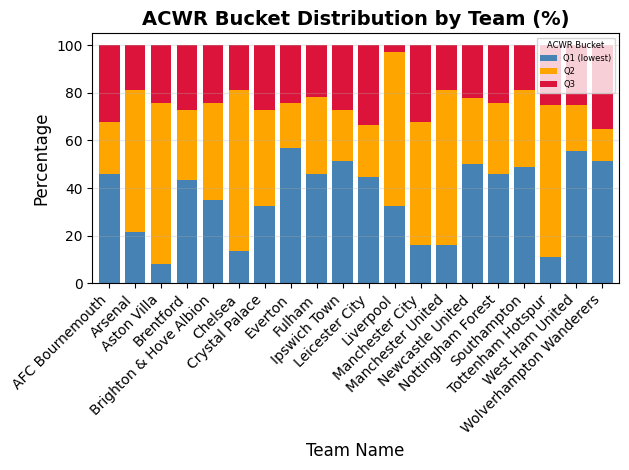

In [722]:
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Create percentage stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab_percent.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution by Team (%)', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [723]:
group_col = ["event_id","match_date","shot_team_id"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)
teamname_agg = team_agg_df.merge(teamlist, on="shot_team_id",how="left")
teamname_agg = teamname_agg[teamname_agg.team_name.isin(standard_pl_teams)]
teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'], format='%Y-%m-%d')
teamname_agg = teamname_agg[teamname_agg.match_date>dt.datetime(2024,8,1)]


<Figure size 1200x600 with 0 Axes>

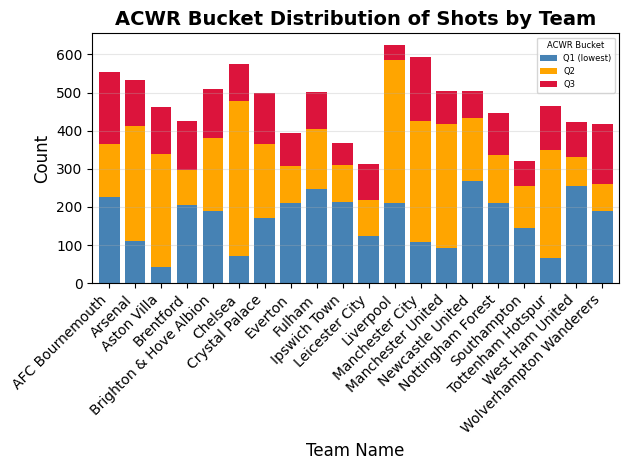

In [724]:
cross_tab = pd.crosstab(teamname_agg['team_name'], teamname_agg['ACWR_bucket'])

# Ensure all 4 ACWR buckets are present (even if some have zero counts)
all_buckets = ['Q1 (lowest)', 'Q2', 'Q3']
for bucket in all_buckets:
    if bucket not in cross_tab.columns:
        cross_tab[bucket] = 0

# Reorder columns to match Q1-Q4 sequence
cross_tab = cross_tab[all_buckets]

# Define colors for each bucket
colors = [ '#4682B4', '#FFA500', '#DC143C']  # '#2E8B57',Q1: green, Q2: blue, Q3: orange, Q4: red

# Create the stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution of Shots by Team', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

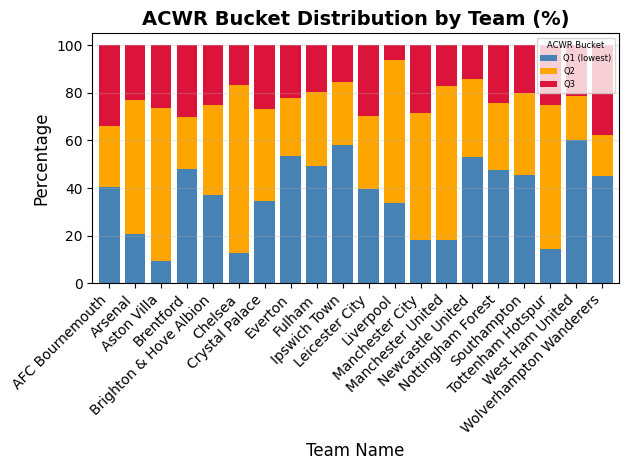

In [725]:
cross_tab = pd.crosstab(teamname_agg['team_name'], teamname_agg['ACWR_bucket'])
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Create percentage stacked bar chart
plt.figure(figsize=(12, 6))
ax = cross_tab_percent.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('ACWR Bucket Distribution by Team (%)', fontsize=14, fontweight='bold')
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='ACWR Bucket', title_fontsize=6, fontsize=6)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plot acwr for leverkusen vs munich for season leverkusen won

In [726]:
team_agg_df[["ACWR_bucket"]].value_counts(normalize=True)

ACWR_bucket
Q1 (lowest)    0.390221
Q2             0.357494
Q3             0.252286
Name: proportion, dtype: float64

In [727]:
df_wide.quantile([0,0.25,0.5,0.75,1])#use

,index,NaN,Q1 (lowest),Q2,Q3
0.00,0.00,0.016062,0.007980,0.003827,0.003055
0.25,183.75,0.035481,0.034284,0.034616,0.033009
0.50,367.50,0.061264,0.057911,0.060591,0.053645
0.75,551.25,0.173645,0.120156,0.104289,0.103075
1.00,735.00,0.420256,0.568045,0.915033,0.886022


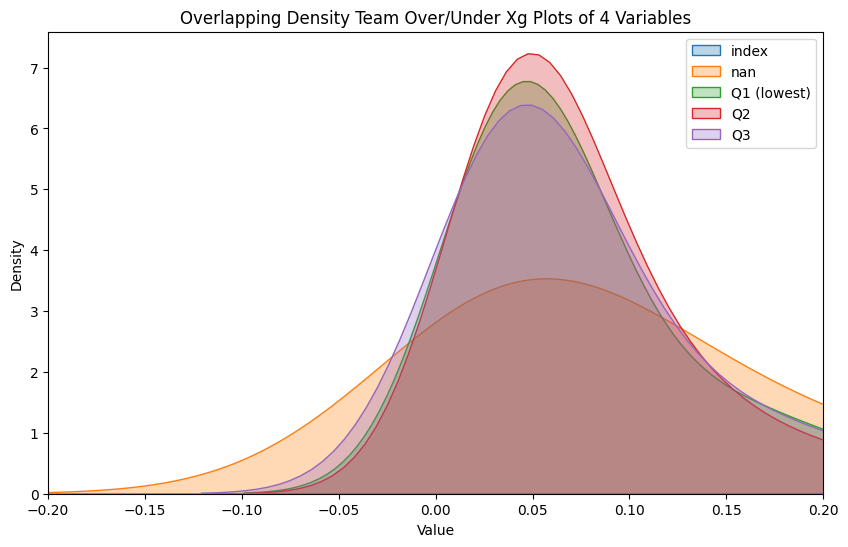

In [728]:
plt.figure(figsize=(10, 6))
for column in df_wide.columns:
    sns.kdeplot(df_wide[column], label=column, fill=True, alpha=0.3)
plt.xlim(-0.2,.2)
plt.title('Overlapping Density Team Over/Under Xg Plots of 4 Variables')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [729]:
df_wide.median()

index          367.500000
NaN              0.061264
Q1 (lowest)      0.057911
Q2               0.060591
Q3               0.053645
dtype: float64

In [730]:
df_wide.mean()

index          367.500000
NaN              0.130974
Q1 (lowest)      0.100079
Q2               0.092230
Q3               0.093335
dtype: float64

In [731]:
group_col = ["event_id","shot_team_id","match_date"]#
mean_col = "over_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')], #bins=[-float('inf'), 0.01, 1, float('inf')],# bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)

team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='over_xg_first').fillna(0).reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)

In [732]:
team_agg_df

,event_id,shot_team_id,match_date,over_xg_first,ACWR_mean,ACWR_bucket
0,000192ca-5d86-4797-af38-7fe2d14d9861,24.0,2024-09-14,-0.068080,1.644497,Q2
1,0005426e-2055-411b-9e10-36af8f9afb72,214.0,2025-04-22,-0.028856,2.001836,Q2
5,00074cc7-844c-43ca-b79d-291be3da4d6e,212.0,2024-11-30,-0.022532,2.231522,Q2
7,000821fd-7d49-4fd3-9238-e5e299801e5d,39.0,2024-11-10,-0.029118,2.029390,Q2
8,000854dc-4d6b-45cd-ac57-e8ad16e5fe5d,182.0,2024-11-02,-0.210336,1.754355,Q2
...,...,...,...,...,...,...
43961,fff10ce0-ab64-47aa-b66e-4392d27fc3e5,37.0,2023-10-28,-0.140125,2.525791,Q3
43963,fff1900c-6ff6-45cb-b30b-a8d2a64329da,207.0,2024-11-29,-0.122133,5.151230,Q3
43964,fffaf9f5-f849-41ac-885e-4f78e6fa503d,182.0,2024-03-15,0.932078,1.262969,Q2
43965,fffb3836-1bcc-4cfa-9c6a-f6c54e63a4e6,36.0,2024-12-04,-0.053872,2.552026,Q3


<Figure size 1600x800 with 0 Axes>

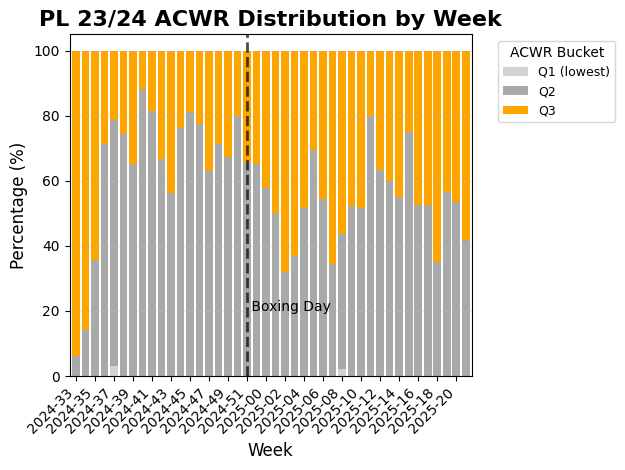

In [733]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
df = team_agg_df[["match_date","shot_team_id","ACWR_bucket"]].drop_duplicates()
df['match_date'] = pd.to_datetime(df['match_date'], format='%Y-%m-%d')
df = df[df.match_date>datetime(2024,8,1)]
# Convert match_date to datetime if not already
df['match_date'] = pd.to_datetime(df['match_date'], format='%Y-%m-%d')
#date_string= pd.to_datetime('2024-12-26')#
target_week = pd.to_datetime('2024-12-26').date().strftime("%Y-%U")

# Extract year-week for grouping (you can also use year-month if preferred)
df['year_week'] = df['match_date'].dt.strftime('%Y-%U')  # %U gives week number

# Create cross-tabulation of weeks vs ACWR_bucket counts
cross_tab = pd.crosstab(df['year_week'], df['ACWR_bucket'])
vertical_line_date1 = list(cross_tab.index).index(target_week)
# Ensure all 4 ACWR buckets are present
all_buckets = ['Q1 (lowest)', 'Q2', 'Q3']
for bucket in all_buckets:
    if bucket not in cross_tab.columns:
        cross_tab[bucket] = 0

# Reorder columns to match Q1-Q4 sequence
cross_tab = cross_tab[all_buckets]

# Convert counts to percentages for each week
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Define colors for each bucket
colors = ['#2E8B57', '#4682B4', '#FFA500', '#DC143C']
colors = ['#D3D3D3', '#A9A9A9', '#FFA500', '#DC143C']
# Create the percentage stacked bar chart
plt.figure(figsize=(16, 8))
ax = cross_tab_percent.plot(kind='bar', stacked=True, color=colors, width=0.8)

plt.title('PL 23/24 ACWR Distribution by Week', fontsize=16, fontweight='bold')
plt.xlabel('Week', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
x_labels = [str(period) for period in cross_tab.index]
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
ax.set_xticks(ax.get_xticks()[::2])  # Show every second tick
ax.set_xticklabels(x_labels[::2])
plt.axvline(x=vertical_line_date1, color='black', linestyle='--', linewidth=2, alpha=0.7, 
            label='')
plt.text(vertical_line_date1,20,' Boxing Day')
plt.legend(title='ACWR Bucket', title_fontsize=10, fontsize=9, 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

maybe caution that a lot of this is in the early weeks and maybe i'm just describing match sharpness or something

In [734]:
group_col = ["shot_team_id","match_date"]#
mean_col = "over_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, .21, .98, float('inf')], # bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3", "Q4"]
)

#team_agg_df = team_agg_df[team_agg_df["ACWR_mean"]>0]
#df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='over_xg_first').fillna(0).reset_index()
#df_wide.columns.name = None
##df_wide = df_wide.drop('event_id',axis=1)
#df_wide

In [735]:
group_col = ["shot_team_id","match_date"]#
mean_col = "statsbomb_xg"#'statsbomb_xg'

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]

#team_agg_df["ACWR_mean"] = team_agg_df["WI_game_mean"]
    

In [736]:
teamname_agg = team_agg_df.merge(teamlist, on="shot_team_id",how="left")

In [737]:
teamname_agg['match_date'] = pd.to_datetime(teamname_agg['match_date'], format='%Y-%m-%d')
df = df[df.match_date>dt.datetime(2024,8,1)]
german_title_race = teamname_agg[((teamname_agg.shot_team_id==169)|(teamname_agg.shot_team_id==904))&(teamname_agg.match_date>datetime(2023,8,1))&
  (teamname_agg.match_date<datetime(2024,8,1))           ]


In [738]:
german_title_race

,shot_team_id,match_date,statsbomb_xg_first,ACWR_mean,team_name
1476,169.0,2023-08-27,0.044322,0.000000,Bayern Munich
1477,169.0,2023-09-02,0.070151,5.072225,Bayern Munich
1478,169.0,2023-09-15,0.063358,1.931113,Bayern Munich
1479,169.0,2023-09-23,0.195917,1.438637,Bayern Munich
1480,169.0,2023-09-30,0.316730,1.406002,Bayern Munich
...,...,...,...,...,...
3348,904.0,2024-04-21,0.007528,1.550598,Bayer Leverkusen
3349,904.0,2024-04-27,0.027029,1.698370,Bayer Leverkusen
3350,904.0,2024-05-05,0.024850,0.951493,Bayer Leverkusen
3351,904.0,2024-05-12,0.071946,0.962218,Bayer Leverkusen


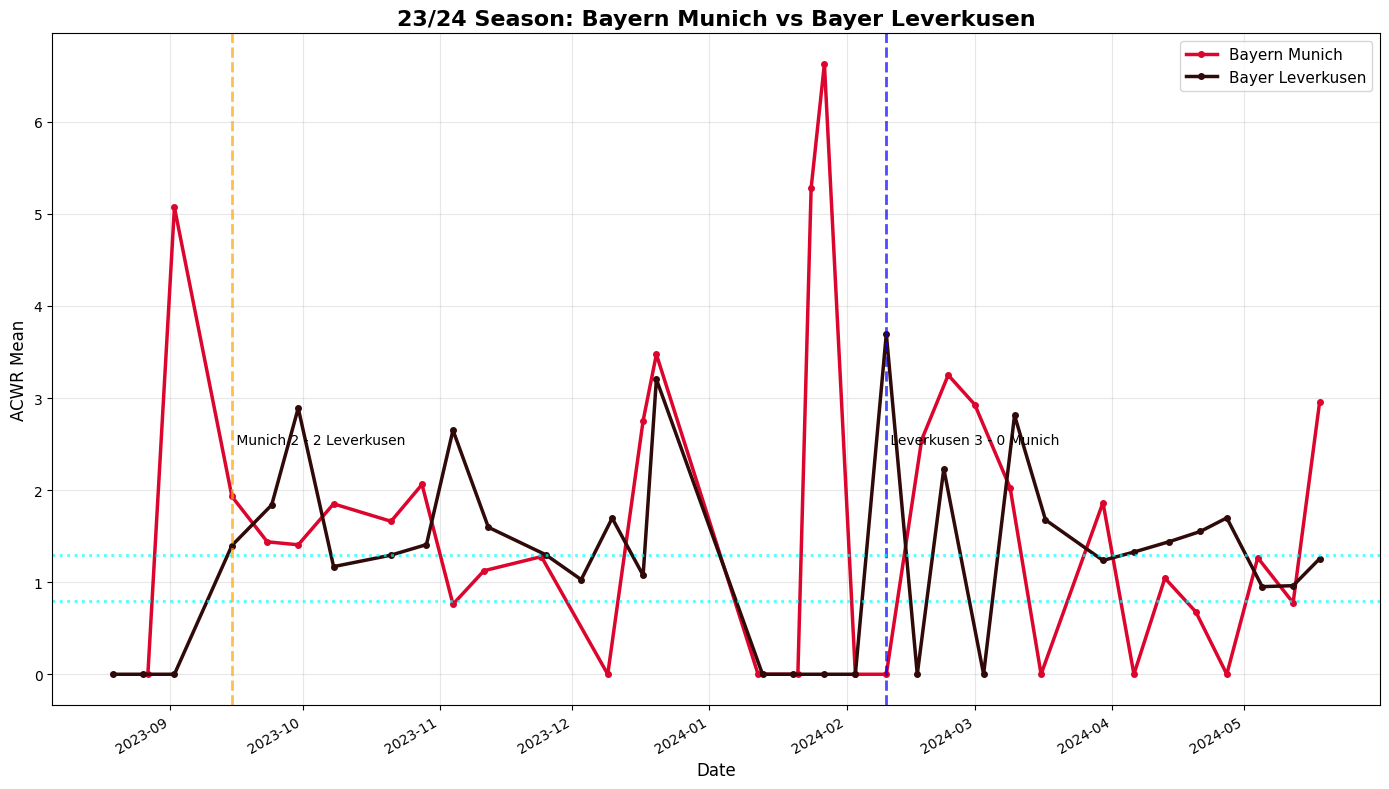

In [739]:
vertical_line_date1 = pd.to_datetime('2024-02-10')
vertical_line_date2 = pd.to_datetime('2023-09-15')
df_filtered = german_title_race.sort_values('match_date')
teams_to_plot = ['Bayern Munich', 'Bayer Leverkusen']
# Define team colors (traditional club colors)
team_colors = {
    'Bayern Munich': '#DC052D',  # Bayern red
    'Bayer Leverkusen': "#300909"   # Leverkusen black
}

# Create the line plot
plt.figure(figsize=(14, 8))

# Plot each team's ACWR_mean over time
for team in teams_to_plot:
    team_data = df_filtered[df_filtered['team_name'] == team]
    plt.plot(team_data['match_date'], team_data['ACWR_mean'], 
             label=team, color=team_colors[team], linewidth=2.5, marker='o', markersize=4)

plt.title('23/24 Season: Bayern Munich vs Bayer Leverkusen', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('ACWR Mean', fontsize=12)

plt.axvline(x=vertical_line_date1, color='blue', linestyle='--', linewidth=2, alpha=0.7, 
            label='')
plt.text(vertical_line_date2,2.5,' Munich 2 - 2 Leverkusen')
plt.axvline(x=vertical_line_date2, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
            label='')
plt.text(vertical_line_date1,2.5,' Leverkusen 3 - 0 Munich')
plt.axhline(y=0.8, color='cyan', linestyle=':', linewidth=2, alpha=0.7)
plt.axhline(y=1.3, color='cyan', linestyle=':', linewidth=2, alpha=0.7)
# Format x-axis dates
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()  # Auto-format dates for better readability

plt.tight_layout()
plt.show()

In [740]:
group_col = ["event_id","shot_team_id"]#
mean_col = 'statsbomb_xg'#"over_xg"#

other_cols = ["ACWR"]

agg_dict = {mean_col: ['first']}
agg_dict.update({col: 'mean' for col in other_cols if col != mean_col})

team_agg_df = team_metrics_df.groupby(group_col, as_index=False).agg(agg_dict)

# Flatten column names
team_agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] 
                                for col in team_agg_df.columns]
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR_mean"],
    bins=[-float('inf'), 0.01, 1, float('inf')], # bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Q1 (lowest)", "Q2", "Q3"]
)
df_wide = team_agg_df.pivot(index='event_id', columns='ACWR_bucket', values='statsbomb_xg_first').fillna(0).reset_index()
df_wide.columns.name = None
df_wide = df_wide.drop('event_id',axis=1)


In [741]:
df_wide.mean()

Q1 (lowest)    0.037799
Q2             0.002852
Q3             0.057303
dtype: float64

In [742]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
def analyze_weak_relationship(df, group_var, value_var):
    """
    Specifically analyze cases with low R² but significant p-value
    """
    # Perform ANOVA
    model = ols(f'{value_var} ~ C({group_var})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    r_squared = model.rsquared
    p_value = anova_table['PR(>F)'][0]
    
    print("=== ANALYSIS OF WEAK BUT SIGNIFICANT RELATIONSHIP ===")
    print(f"R-squared: {r_squared:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05 and r_squared < 0.1:
        print("\nINTERPRETATION:")
        print("✓ Statistically significant (p < 0.05)")
        print("✓ But practically weak (R² < 0.10)")
        print("→ The group means are reliably different, but the")
        print("  grouping variable explains very little variance.")
        print("→ This is common with large sample sizes.")
    
    # Show group means and variability
    print(f"\nGROUP STATISTICS:")
    stats = df.groupby(group_var)[value_var].agg(['mean', 'std', 'count'])
    print(stats.round(2))
    
    # Calculate percentage differences from overall mean
    overall_mean = df[value_var].mean()
    stats['pct_diff'] = ((stats['mean'] - overall_mean) / overall_mean * 100).round(2)
    print(f"\nPERCENTAGE DIFFERENCES FROM OVERALL MEAN:")
    print(stats[['mean', 'pct_diff']])

# analyze_weak_relationship(df, 'X', 'y')

In [743]:
team_agg_df.groupby("ACWR_bucket")["statsbomb_xg_first"].agg(['mean', 'std', 'count'])


C:\Users\conny\AppData\Local\Temp\ipykernel_3712\579783506.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  team_agg_df.groupby("ACWR_bucket")["statsbomb_xg_first"].agg(['mean', 'std', 'count'])


,mean,std,count
ACWR_bucket,,,
Q1 (lowest),0.096867,0.118477,17158
Q2,0.105036,0.134759,1194
Q3,0.098353,0.121185,25618


In [744]:
analyze_weak_relationship(team_agg_df,"ACWR_bucket", "statsbomb_xg_first")

=== ANALYSIS OF WEAK BUT SIGNIFICANT RELATIONSHIP ===
R-squared: 0.0001
P-value: 0.0551

GROUP STATISTICS:
             mean   std  count
ACWR_bucket                   
Q1 (lowest)  0.10  0.12  17158
Q2           0.11  0.13   1194
Q3           0.10  0.12  25618

PERCENTAGE DIFFERENCES FROM OVERALL MEAN:
                 mean  pct_diff
ACWR_bucket                    
Q1 (lowest)  0.096867     -1.11
Q2           0.105036      7.23
Q3           0.098353      0.41


C:\Users\conny\AppData\Local\Temp\ipykernel_3712\1553423902.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\conny\AppData\Local\Temp\ipykernel_3712\1553423902.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(group_var)[value_var].agg(['mean', 'std', 'count'])


In [745]:
team_metrics_df.head(1)

,Unnamed: 0,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,event_id,gameId,player_id,shooter_id_x,match_date,minute,event_index,period,timestamp,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,shot_team_id,team_name,location_x,location_y,location_z,related_events,shooter_id_y,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,Total Distance_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Count Sprint_1_week,Count Medium Deceleration_1_week,Count Medium Acceleration_1_week,Count High Deceleration_1_week,Count High Acceleration_1_week,Count HSR_1_week,Count HI_1_week,nan_1_week,Total Distance_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Count Sprint_2_week,Count Medium Deceleration_2_week,Count Medium Acceleration_2_week,Count High Deceleration_2_week,Count High Acceleration_2_week,Count HSR_2_week,Count HI_2_week,nan_2_week,Total Distance_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Count Sprint_1_month,Count Medium Deceleration_1_month,Count Medium Acceleration_1_month,Count High Deceleration_1_month,Count High Acceleration_1_month,Count HSR_1_month,Count HI_1_month,nan_1_month,shooter_id,birth_date,over_xg,WI_now,WI_half,WI_game,WI_1_week,WI_2_week,WI_1_month,ACWR,ACWR_bucket,ACWR_pos
2927,2927,0.933333,0.933333,0.933333,0.666667,0.666667,0.666667,0.266667,0.266667,0.266667,0.933333,0.933333,0.933333,4.933333,4.933333,4.933333,4.133333,4.133333,4.133333,0.266667,0.266667,0.266667,16.408821,16.408821,16.408821,10.502309,10.502309,10.502309,15.20968,15.20968,15.20968,4.096761,4.096761,4.096761,24.14317,24.14317,24.14317,5.906512,5.906512,5.906512,228.145194,228.145194,228.145194,580689a4-dacb-4cf9-b043-cf5495a8a484,3892765,6374.0,3951.0,2023-08-19,2.0,109.0,1.0,00:02:41.470,41.0,7.0,0.57444,0.053282,0.066325,-0.013043,0.010668,0.010668,0.0,-0.013043,True,16.0,Shot,46.0,Wolverhampton Wanderers,1.0,Regular Play,46.0,Wolverhampton Wanderers,99.1,40.1,0.0,"9eb6487f-ad8b-4aab-a6bc-c36ebc04d547, 9a031553...",3951.0,Mario Lemina,11.0,Left Defensive Midfield,0.053282,0.0,0.0,Left Foot,1.0,10768.214187,1187.996338,682.289001,105.830115,33.453089,1257.914062,505.707306,25.0,178.0,184.0,45.0,39.0,49.0,74.0,0.0,10768.214187,1187.996338,682.289001,105.830115,33.453089,1257.914062,505.707306,25.0,178.0,184.0,45.0,39.0,49.0,74.0,0.0,10768.214187,1187.996338,682.289001,105.830115,33.453089,1257.914062,505.707306,25.0,178.0,184.0,45.0,39.0,49.0,74.0,0.0,3951.0,1993-11-16,-0.053282,1.923933,1.793288,0.049202,0.441806,0.296634,0.172298,10.2

In [746]:
team_metrics_df[["gameId","shot_team_id","ACWR_bucket","event_id","player_id"]].groupby(["gameId","shot_team_id","ACWR_bucket","event_id"],as_index=False, observed= True).nunique()

,gameId,shot_team_id,ACWR_bucket,event_id,player_id
0,3892765,35.0,Q1 (lowest),157fdd0c-e5e5-4a1e-a971-685fb0ce2a4e,9
1,3892765,35.0,Q1 (lowest),18a4b290-1007-414e-a6dd-4b7da7608a8d,9
2,3892765,35.0,Q1 (lowest),19e199ce-2625-4f58-a8d7-c9321540c029,9
3,3892765,35.0,Q1 (lowest),2ed12cdc-0fb5-4524-9e3d-ce4e43749da4,9
4,3892765,35.0,Q1 (lowest),34ed1433-f402-46ec-984d-511a1e5ff1ae,9
...,...,...,...,...,...
82019,3956010,93.0,Q1 (lowest),9d5cf308-52ee-4e11-8c75-4fd8fbae13a7,11
82020,3956010,93.0,Q1 (lowest),a9e4edcb-b764-420b-8115-587efde3335d,11
82021,3956010,93.0,Q1 (lowest),cc0b62e4-7342-48f8-a0e2-740d0b1c8af5,11
82022,3956010,93.0,Q1 (lowest),d7c337f1-f534-4c09-a615-992324e68540,11


In [747]:
team_metrics_df.head(1)

,Unnamed: 0,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,event_id,gameId,player_id,shooter_id_x,match_date,minute,event_index,period,timestamp,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,shot_team_id,team_name,location_x,location_y,location_z,related_events,shooter_id_y,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,Total Distance_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Count Sprint_1_week,Count Medium Deceleration_1_week,Count Medium Acceleration_1_week,Count High Deceleration_1_week,Count High Acceleration_1_week,Count HSR_1_week,Count HI_1_week,nan_1_week,Total Distance_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Count Sprint_2_week,Count Medium Deceleration_2_week,Count Medium Acceleration_2_week,Count High Deceleration_2_week,Count High Acceleration_2_week,Count HSR_2_week,Count HI_2_week,nan_2_week,Total Distance_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Count Sprint_1_month,Count Medium Deceleration_1_month,Count Medium Acceleration_1_month,Count High Deceleration_1_month,Count High Acceleration_1_month,Count HSR_1_month,Count HI_1_month,nan_1_month,shooter_id,birth_date,over_xg,WI_now,WI_half,WI_game,WI_1_week,WI_2_week,WI_1_month,ACWR,ACWR_bucket,ACWR_pos
2927,2927,0.933333,0.933333,0.933333,0.666667,0.666667,0.666667,0.266667,0.266667,0.266667,0.933333,0.933333,0.933333,4.933333,4.933333,4.933333,4.133333,4.133333,4.133333,0.266667,0.266667,0.266667,16.408821,16.408821,16.408821,10.502309,10.502309,10.502309,15.20968,15.20968,15.20968,4.096761,4.096761,4.096761,24.14317,24.14317,24.14317,5.906512,5.906512,5.906512,228.145194,228.145194,228.145194,580689a4-dacb-4cf9-b043-cf5495a8a484,3892765,6374.0,3951.0,2023-08-19,2.0,109.0,1.0,00:02:41.470,41.0,7.0,0.57444,0.053282,0.066325,-0.013043,0.010668,0.010668,0.0,-0.013043,True,16.0,Shot,46.0,Wolverhampton Wanderers,1.0,Regular Play,46.0,Wolverhampton Wanderers,99.1,40.1,0.0,"9eb6487f-ad8b-4aab-a6bc-c36ebc04d547, 9a031553...",3951.0,Mario Lemina,11.0,Left Defensive Midfield,0.053282,0.0,0.0,Left Foot,1.0,10768.214187,1187.996338,682.289001,105.830115,33.453089,1257.914062,505.707306,25.0,178.0,184.0,45.0,39.0,49.0,74.0,0.0,10768.214187,1187.996338,682.289001,105.830115,33.453089,1257.914062,505.707306,25.0,178.0,184.0,45.0,39.0,49.0,74.0,0.0,10768.214187,1187.996338,682.289001,105.830115,33.453089,1257.914062,505.707306,25.0,178.0,184.0,45.0,39.0,49.0,74.0,0.0,3951.0,1993-11-16,-0.053282,1.923933,1.793288,0.049202,0.441806,0.296634,0.172298,10.2

In [748]:
team_agg_df = team_metrics_df[["gameId","shot_team_id","ACWR","event_id"]].groupby(["gameId","shot_team_id","event_id"],as_index=False, observed= True).mean()


In [749]:
team_agg_df["ACWR_bucket"] = pd.cut(
    team_agg_df["ACWR"],
    bins=[-float('inf'), 0.01, 2.5, float('inf')],#bins=[-float('inf'), 0.01, 1, float('inf')], # bins=[-float('inf'), 0.8, 1.3, 2, float('inf')],
    labels=["Zero", "Zero to One", "One to Four", ]
)

In [750]:
team_agg_df

,gameId,shot_team_id,event_id,ACWR,ACWR_bucket
0,3892765,35.0,157fdd0c-e5e5-4a1e-a971-685fb0ce2a4e,0.0,Zero
1,3892765,35.0,18a4b290-1007-414e-a6dd-4b7da7608a8d,0.0,Zero
2,3892765,35.0,19e199ce-2625-4f58-a8d7-c9321540c029,0.0,Zero
3,3892765,35.0,2ed12cdc-0fb5-4524-9e3d-ce4e43749da4,0.0,Zero
4,3892765,35.0,34ed1433-f402-46ec-984d-511a1e5ff1ae,0.0,Zero
...,...,...,...,...,...
43965,3956010,93.0,9d5cf308-52ee-4e11-8c75-4fd8fbae13a7,0.0,Zero
43966,3956010,93.0,a9e4edcb-b764-420b-8115-587efde3335d,0.0,Zero
43967,3956010,93.0,cc0b62e4-7342-48f8-a0e2-740d0b1c8af5,0.0,Zero
43968,3956010,93.0,d7c337f1-f534-4c09-a615-992324e68540,0.0,Zero


In [751]:
shot_volume = team_agg_df[["gameId","shot_team_id","ACWR","event_id"]].groupby(["gameId","shot_team_id","ACWR"],as_index=False, observed= True).agg({'ACWR' : 'mean', 'event_id' : 'nunique'}).reindex()
shot_volume

,gameId,shot_team_id,ACWR,event_id
0,3892765,35.0,0.000000,16
1,3892765,46.0,10.256797,8
2,3892765,46.0,10.256797,8
3,3892766,29.0,0.000000,9
4,3892766,59.0,0.000000,12
...,...,...,...,...
7410,3956009,38.0,2.401386,2
7411,3956010,46.0,2.226862,14
7412,3956010,46.0,2.552907,3
7413,3956010,46.0,3.062405,1


In [752]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np

def analyze_weak_relationship_numeric(df, x_var, y_var):
    """
    Specifically analyze cases with low R² but significant p-value
    for two numeric variables
    """
    # Perform linear regression
    model = ols(f'{y_var} ~ {x_var}', data=df).fit()
    
    r_squared = model.rsquared
    p_value = model.f_pvalue
    
    print("=== ANALYSIS OF WEAK BUT SIGNIFICANT RELATIONSHIP ===")
    print(f"R-squared: {r_squared:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Slope: {model.params[x_var]:.4f}")
    print(f"Intercept: {model.params['Intercept']:.4f}")
    
    # Detailed coefficient analysis
    print(f"\n=== DETAILED COEFFICIENT ANALYSIS ===")
    coef_summary = pd.DataFrame({
        'Coefficient': model.params,
        'Std_Error': model.bse,
        't-value': model.tvalues,
        'p-value': model.pvalues
    })
    print(coef_summary.round(4))
    
    # Confidence intervals for coefficients
    print(f"\n=== COEFFICIENT CONFIDENCE INTERVALS ===")
    conf_int = model.conf_int()
    conf_int.columns = ['2.5%', '97.5%']
    print(conf_int.round(4))
    
    if p_value < 0.05 and r_squared < 0.1:
        print("\nINTERPRETATION:")
        print("✓ Statistically significant (p < 0.05)")
        print("✓ But practically weak (R² < 0.10)")
        print("→ The relationship is reliably non-zero, but the")
        print("  predictor variable explains very little variance.")
        print("→ This is common with large sample sizes.")
        print("→ The effect exists but is very small in practical terms.")
        
        # Practical interpretation of slope
        slope = model.params[x_var]
        x_range = df[x_var].max() - df[x_var].min()
        y_effect = slope * x_range
        y_mean = df[y_var].mean()
        pct_effect = (y_effect / y_mean) * 100
        
        print(f"\nPRACTICAL INTERPRETATION OF SLOPE:")
        print(f"→ For each 1-unit increase in {x_var}, {y_var} changes by {slope:.4f} units")
        print(f"→ Across the full range of {x_var} ({x_range:.2f} units),")
        print(f"  {y_var} changes by {y_effect:.2f} units ({pct_effect:.1f}% of mean)")
    
    # Show descriptive statistics
    print(f"\nVARIABLE STATISTICS:")
    stats = pd.DataFrame({
        'Variable': [x_var, y_var],
        'Mean': [df[x_var].mean(), df[y_var].mean()],
        'Std': [df[x_var].std(), df[y_var].std()],
        'Min': [df[x_var].min(), df[y_var].min()],
        'Max': [df[x_var].max(), df[y_var].max()],
        'Count': [len(df), len(df)]
    })
    print(stats.round(2))
    
    # Calculate correlation for additional insight
    correlation = df[x_var].corr(df[y_var])
    print(f"\nCORRELATION ANALYSIS:")
    print(f"Pearson correlation: {correlation:.4f}")
    print(f"Absolute correlation: {abs(correlation):.4f}")
    
    # Effect size interpretation
    print(f"\nEFFECT SIZE INTERPRETATION:")
    if abs(correlation) < 0.1:
        print("✓ Very small effect")
    elif abs(correlation) < 0.3:
        print("✓ Small effect")
    elif abs(correlation) < 0.5:
        print("✓ Medium effect")
    else:
        print("✓ Large effect")
    
    return model

# Enhanced version with even more coefficient insights
def analyze_weak_relationship_numeric_detailed(df, x_var, y_var, bins=5):
    """
    Enhanced version with detailed coefficient diagnostics
    """
    # Basic analysis
    model = analyze_weak_relationship_numeric(df, x_var, y_var)
    
    # Additional coefficient diagnostics
    print(f"\n{'='*50}")
    print("ADDITIONAL COEFFICIENT DIAGNOSTICS:")
    
    # Standardized coefficients (beta weights)
    x_std = df[x_var].std()
    y_std = df[y_var].std()
    standardized_slope = model.params[x_var] * (x_std / y_std)
    print(f"Standardized coefficient (beta): {standardized_slope:.4f}")
    
    # Coefficient of variation analysis
    cv_x = (df[x_var].std() / df[x_var].mean()) * 100
    cv_y = (df[y_var].std() / df[y_var].mean()) * 100
    print(f"\nCoefficient of Variation:")
    print(f"{x_var}: {cv_x:.1f}%")
    print(f"{y_var}: {cv_y:.1f}%")
    
    # Practical significance thresholds
    slope = model.params[x_var]
    y_mean = df[y_var].mean()
    practical_effect = abs(slope) / y_std  # Effect in standard deviations
    
    print(f"\nPRACTICAL SIGNIFICANCE:")
    print(f"Effect size (Cohen's d): {practical_effect:.4f}")
    if practical_effect < 0.2:
        print("→ Very small practical effect")
    elif practical_effect < 0.5:
        print("→ Small practical effect")
    elif practical_effect < 0.8:
        print("→ Medium practical effect")
    else:
        print("→ Large practical effect")
    
    return model

In [753]:
analyze_weak_relationship_numeric(shot_volume, "ACWR","event_id")

=== ANALYSIS OF WEAK BUT SIGNIFICANT RELATIONSHIP ===
R-squared: 0.1225
P-value: 0.0000
Slope: -1.1964
Intercept: 8.4298

=== DETAILED COEFFICIENT ANALYSIS ===
           Coefficient  Std_Error  t-value  p-value
Intercept       8.4298     0.0970  86.9303      0.0
ACWR           -1.1964     0.0372 -32.1722      0.0

=== COEFFICIENT CONFIDENCE INTERVALS ===
             2.5%   97.5%
Intercept  8.2397  8.6199
ACWR      -1.2692 -1.1235

VARIABLE STATISTICS:
   Variable  Mean   Std  Min    Max  Count
0      ACWR  2.09  1.56  0.0  10.26   7415
1  event_id  5.93  5.33  1.0  34.00   7415

CORRELATION ANALYSIS:
Pearson correlation: -0.3500
Absolute correlation: 0.3500

EFFECT SIZE INTERPRETATION:
✓ Medium effect


In [754]:
shot_volume

,gameId,shot_team_id,ACWR,event_id
0,3892765,35.0,0.000000,16
1,3892765,46.0,10.256797,8
2,3892765,46.0,10.256797,8
3,3892766,29.0,0.000000,9
4,3892766,59.0,0.000000,12
...,...,...,...,...
7410,3956009,38.0,2.401386,2
7411,3956010,46.0,2.226862,14
7412,3956010,46.0,2.552907,3
7413,3956010,46.0,3.062405,1


<Axes: xlabel='event_id', ylabel='ACWR'>

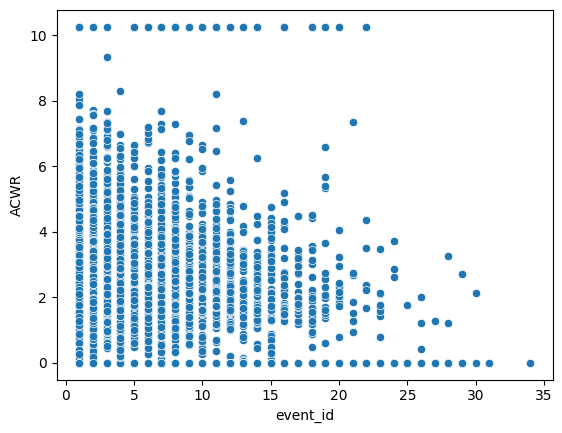

In [755]:
sns.scatterplot(data=shot_volume, x="event_id", y="ACWR")

In [756]:
shot_volume = team_agg_df[["gameId","shot_team_id","ACWR_bucket","event_id"]].groupby(["gameId","shot_team_id","ACWR_bucket"],as_index=False, observed= True).nunique()

In [757]:
shot_volume

,gameId,shot_team_id,ACWR_bucket,event_id
0,3892765,35.0,Zero,16
1,3892765,46.0,One to Four,16
2,3892766,29.0,Zero,9
3,3892766,59.0,Zero,12
4,3892767,1.0,Zero,13
...,...,...,...,...
3821,3956009,35.0,One to Four,22
3822,3956009,38.0,Zero to One,3
3823,3956010,46.0,Zero to One,14
3824,3956010,46.0,One to Four,4


In [758]:
shot_volume[["ACWR_bucket","event_id"]].groupby("ACWR_bucket",as_index=False).count()

C:\Users\conny\AppData\Local\Temp\ipykernel_3712\2333831963.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shot_volume[["ACWR_bucket","event_id"]].groupby("ACWR_bucket",as_index=False).count()


,ACWR_bucket,event_id
0,Zero,1385
1,Zero to One,1376
2,One to Four,1065


In [759]:
shot_volume[["ACWR_bucket","event_id"]].groupby("ACWR_bucket",as_index=False).mean()

C:\Users\conny\AppData\Local\Temp\ipykernel_3712\3300758312.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shot_volume[["ACWR_bucket","event_id"]].groupby("ACWR_bucket",as_index=False).mean()


,ACWR_bucket,event_id
0,Zero,12.388448
1,Zero to One,11.423692
2,One to Four,10.415962


In [760]:
analyze_weak_relationship(shot_volume,"ACWR_bucket", "event_id")

=== ANALYSIS OF WEAK BUT SIGNIFICANT RELATIONSHIP ===
R-squared: 0.0169
P-value: 0.0000

INTERPRETATION:
✓ Statistically significant (p < 0.05)
✓ But practically weak (R² < 0.10)
→ The group means are reliably different, but the
  grouping variable explains very little variance.
→ This is common with large sample sizes.

GROUP STATISTICS:
              mean   std  count
ACWR_bucket                    
Zero         12.39  5.31   1385
Zero to One  11.42  6.62   1376
One to Four  10.42  5.95   1065

PERCENTAGE DIFFERENCES FROM OVERALL MEAN:
                  mean  pct_diff
ACWR_bucket                     
Zero         12.388448      7.80
Zero to One  11.423692     -0.60
One to Four  10.415962     -9.37


C:\Users\conny\AppData\Local\Temp\ipykernel_3712\1553423902.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
C:\Users\conny\AppData\Local\Temp\ipykernel_3712\1553423902.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby(group_var)[value_var].agg(['mean', 'std', 'count'])


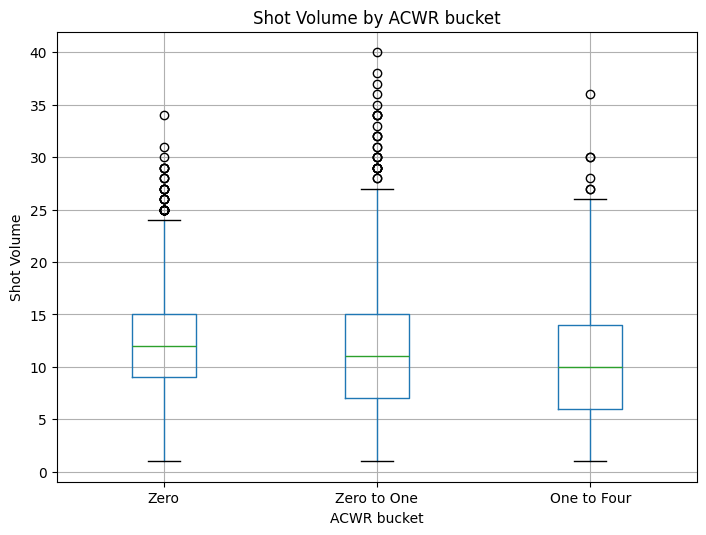

In [761]:
df = shot_volume.copy()
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column="event_id", by="ACWR_bucket", ax=ax)

# Beautify
ax.set_title("Shot Volume by ACWR bucket")
ax.set_xlabel("ACWR bucket")
ax.set_ylabel("Shot Volume")
plt.suptitle("")  # remove automatic "Boxplot grouped by..." title
plt.show()